# DATA620 - Assignment 10

### Group # 1 Adam Gersowitz, Diego Correa, Maria A Ginorio

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

In [171]:
#Load Packages

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot  as plt

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix

import joblib
import os

## About the Data

The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...

Our collection of spam e-mails came from our postmaster and individuals who had filed spam. Our collection of non-spam e-mails came from filed work and personal e-mails, and hence the word 'george' and the area code '650' are indicators of non-spam. These are useful when constructing a personalized spam filter. One would either have to blind such non-spam indicators or get a very wide collection of non-spam to generate a general purpose spam filter.

In [2]:
# first look at data
df = pd.read_csv('spambase.csv')
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## EDA

In [3]:
df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


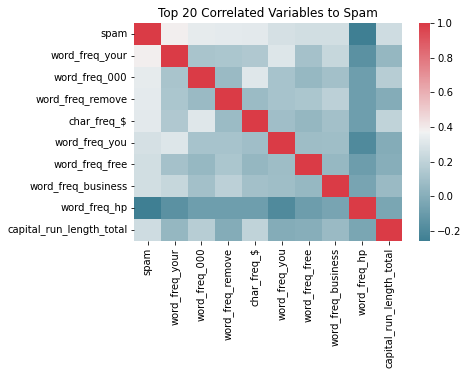

In [4]:
# Perform correlation matrix on top 10 correlated variables
corr = df.corr()

cols = corr.abs().nlargest(10,'spam')['spam'].index
corr_matrix = np.corrcoef(df[cols].values.T)

ax = sns.heatmap(corr_matrix,
                yticklabels = cols.values,
                xticklabels = cols.values,
                cmap = sns.diverging_palette(220, 10, as_cmap=True)
                )
plt.title('Top 20 Correlated Variables to Spam')
plt.show()

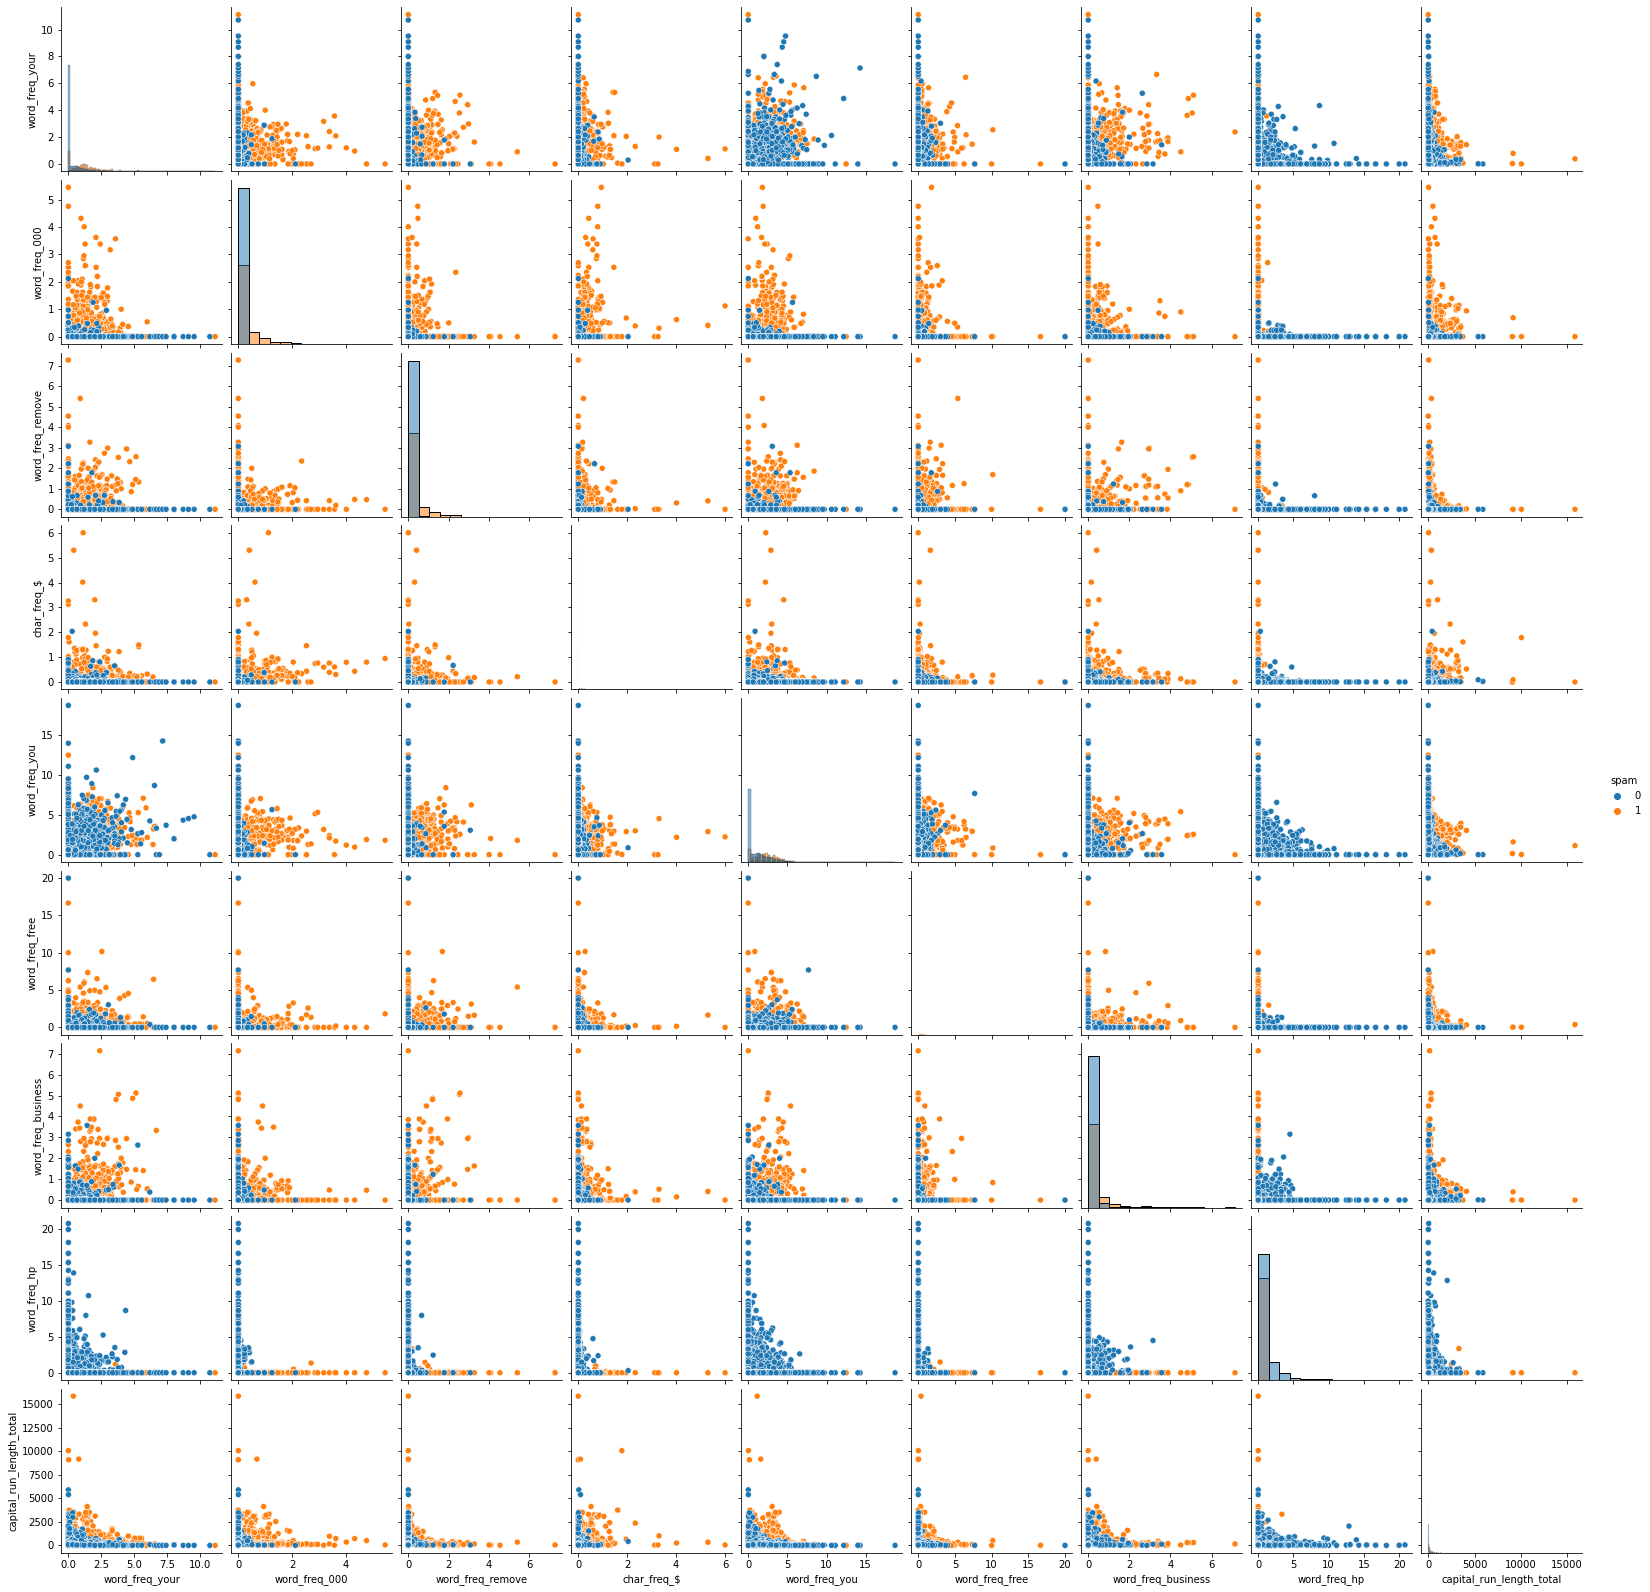

In [12]:
# view distribution among the spam and non spam emails
sns.pairplot(df[cols], hue='spam', diag_kind='hist') 

## Creating Models

We will create 3 models, Random Forest, Naive Bayes, and KNN while storing the performance metrics.  We will then compare and predict on the test data.

Before starting the modeling, we need to identify the training and test datasets. 

In [22]:
y = df['spam']
X = df.drop(['spam'], axis=1)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
scoring = ['accuracy', 'precision_macro', 'roc_auc']

scores = {}

### Random Forest

In [144]:
# creating rf object
rf = RandomForestClassifier()

# create model with 10 cv folds
rf_scores = cross_validate(rf, x_train, y_train, scoring=scoring, cv=10, return_estimator=True)

# store model
rf_fit = rf_scores['estimator']

# storing only the mean of each cross validation metrics
rf_scores.pop('estimator')
rf_scores = {k: v.mean() for k,v in rf_scores.items()}

# add model name to dict and saving to pandas series
rf_scores['model'] = 'rf'
rf_scores

{'fit_time': 0.3573477029800415,
 'score_time': 0.025728130340576173,
 'test_accuracy': 0.9469565217391303,
 'test_precision_macro': 0.9470903721775455,
 'test_recall_macro': 0.941577153351575,
 'test_f1_weighted': 0.9468067299744242,
 'test_roc_auc': 0.9826759694344048,
 'model': 'rf'}

### Naive Bayes

In [131]:
# creating nb object
nb = GaussianNB()

# create model with 10 cv folds
nb_scores = cross_validate(nb, x_train, y_train, scoring=scoring, cv=10, return_estimator=True)

# store model
nb_fit = nb_scores['estimator']

# storing only the mean of each cross validation metrics
nb_scores.pop('estimator')
nb_scores = {k: v.mean() for k,v in nb_scores.items()}

# add model name to dict and saving to pandas series
nb_scores['model'] = 'nb'
nb_scores

{'fit_time': 0.0048874616622924805,
 'score_time': 0.005590677261352539,
 'test_accuracy': 0.8188405797101449,
 'test_precision_macro': 0.8281294076711363,
 'test_recall_macro': 0.8425495257482243,
 'test_f1_weighted': 0.8207317974392957,
 'test_roc_auc': 0.9410100298427618,
 'model': 'nb'}

### KNN

In [130]:
# creating nb object
knn = KNeighborsClassifier()

# create model with 10 cv folds
knn_scores = cross_validate(knn, x_train, y_train, scoring=scoring,cv=10, return_estimator=True)

# store model
knn_fit = knn_scores['estimator']

# storing only the mean of each cross validation metrics
knn_scores.pop('estimator')
knn_scores = {k: v.mean() for k,v in knn_scores.items()}

# add model name to dict and saving to pandas series
knn_scores['model'] = 'knn'
knn_scores

{'fit_time': 0.003264760971069336,
 'score_time': 0.06025640964508057,
 'test_accuracy': 0.7872463768115943,
 'test_precision_macro': 0.7776948572130405,
 'test_recall_macro': 0.7738149038902381,
 'test_f1_weighted': 0.7864046913481179,
 'test_roc_auc': 0.8541144545583723,
 'model': 'knn'}

## Comparing Models

The Random Forest model out performs the othher models at every metric.  We will need to selec the Random Forest model and use it to predict our test data.  Finally, we will compare the predicted and actual data.

In [115]:
metrics = {'rf': rf_scores.values(), 'nb': nb_scores.values(), 'knn': knn_scores.values()}
names = rf_scores.keys()
pd.DataFrame.from_dict(metrics, orient='index', columns=names)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_weighted,test_roc_auc,model
rf,0.352560,0.025931,0.945797,0.945923,0.940368,0.945638,0.982858,rf
nb,0.004583,0.005792,0.818841,0.828129,0.842550,0.820732,0.941010,nb
knn,0.003192,0.055850,0.787246,0.777695,0.773815,0.786405,0.854114,knn


In [156]:
rf_fit = rf_fit[0]
filename = os.path.join(r'C:\Users\Diego Correa\Dropbox\MSDS\DATA620', 'rfmodel.joblib')
joblib.dump(rf_fit, filename)

rf_model = joblib.load(filename)
predicted = rf_model.predict(x_test)

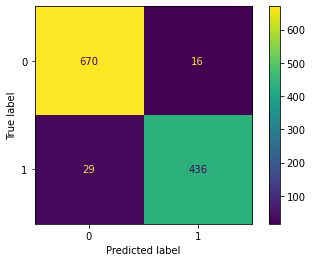

In [172]:
plot_confusion_matrix(rf_model, x_test, y_test)
plt.show()

In [170]:
precision_score(y_test, predicted)

0.9646017699115044